## Disaster Tweets Classification with TFHub

## Table of Contents
- Overview
- Import Packages and Datasets
- Data Wrangling
- Data Preprocessing
- Model Development
- Model Evaluation
- Submission
- Conclusion

# Overview
In this notebook I will build a Text Classifier to read tweets dataset to build predict whether it's talking about disaster.

## Import Packages and Datasets 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.location.value_counts()

USA                          104
New York                      71
United States                 50
London                        45
Canada                        29
                            ... 
The Epicenter, and Beyond      1
Chester                        1
Aix-en-Provence/Utrecht        1
Utica NY                       1
BrasÌ_lia                      1
Name: location, Length: 3341, dtype: int64

## Data Wrangling
Let's see null values for each column.

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
train["keyword"].replace(np.NAN, "", inplace=True)
train["location"].replace(np.NAN, "", inplace=True)
test["keyword"].replace(np.NAN, "", inplace=True)
test["location"].replace(np.NAN, "", inplace=True)

In [9]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [10]:
test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

## Data Preprocessing

In [11]:
contents = []
for data in [train, test]:
    for i in range(data.shape[0]):
        item = data.iloc[i]
        sentence = item["keyword"] + " " + item["text"] + " " + item["location"]
        sentence = sentence.strip().lower()
        contents.append(sentence)

In [12]:
print(len(train), len(test))

7613 3263


In [13]:
x_train = contents[:len(train)]
x_test = contents[len(train):]
y_train = train["target"]
print(len(x_train), len(x_test), y_train.shape)

7613 3263 (7613,)


## Train Validation Split

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=44)

In [15]:
print(len(x_train), len(y_train), len(x_val), len(y_val))

6090 6090 1523 1523


In [16]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Model Development

In [17]:
tf.keras.backend.clear_session()
keras_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    keras_layer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [18]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_accuracy": [],
    "valid_accuracy": []
}
num_epochs = 20
for epoch in range(num_epochs):
    begin_time = time.time()
    train_losses = []
    valid_losses = []
    correct_count = 0
    total_count = 0
    total_train_count = 0
    for (x_batch, y_true) in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            predict_labels = tf.argmax(y_pred, axis=-1)
            loss_value = loss_object(y_true, y_pred)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_train_count += y_true.shape[0]
    train_loss = tf.reduce_mean(train_losses)
    train_accuracy = correct_count / total_train_count
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    correct_count = 0
    total_count = 0
    total_valid_count = 0
    for (x_batch, y_true) in val_dataset:
        y_pred = model(x_batch)
        predict_labels = tf.argmax(y_pred, axis=-1)
        loss_value = loss_object(y_true, y_pred)
        valid_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_valid_count += y_true.shape[0]
    valid_loss = tf.reduce_mean(valid_losses)
    valid_accuracy = correct_count / total_valid_count
    history["valid_loss"].append(valid_loss)
    history["valid_accuracy"].append(valid_accuracy)
    elapsed_time = time.time() -  begin_time
    print("Epoch: %d / %d"%(epoch + 1, num_epochs))
    print("%.2fs Loss: %.2f Accuracy: %.2f Validation Loss: %.2f Validation Accuracy: %.2f"%(elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy))
for key in history:
    history[key] = list(np.array(history[key]))

Epoch: 1 / 20
2.35s Loss: 0.62 Accuracy: 0.66 Validation Loss: 0.56 Validation Accuracy: 0.75
Epoch: 2 / 20
0.96s Loss: 0.54 Accuracy: 0.74 Validation Loss: 0.51 Validation Accuracy: 0.77
Epoch: 3 / 20
1.10s Loss: 0.51 Accuracy: 0.76 Validation Loss: 0.49 Validation Accuracy: 0.77
Epoch: 4 / 20
0.91s Loss: 0.50 Accuracy: 0.76 Validation Loss: 0.49 Validation Accuracy: 0.77
Epoch: 5 / 20
0.91s Loss: 0.49 Accuracy: 0.77 Validation Loss: 0.49 Validation Accuracy: 0.77
Epoch: 6 / 20
0.91s Loss: 0.49 Accuracy: 0.77 Validation Loss: 0.48 Validation Accuracy: 0.76
Epoch: 7 / 20
0.90s Loss: 0.48 Accuracy: 0.77 Validation Loss: 0.48 Validation Accuracy: 0.78
Epoch: 8 / 20
0.90s Loss: 0.48 Accuracy: 0.77 Validation Loss: 0.48 Validation Accuracy: 0.77
Epoch: 9 / 20
0.91s Loss: 0.48 Accuracy: 0.78 Validation Loss: 0.48 Validation Accuracy: 0.77
Epoch: 10 / 20
0.89s Loss: 0.47 Accuracy: 0.78 Validation Loss: 0.48 Validation Accuracy: 0.77
Epoch: 11 / 20
0.91s Loss: 0.47 Accuracy: 0.78 Validation L

## Model Evaluation

**Loss and Accuracy over time**

<AxesSubplot:>

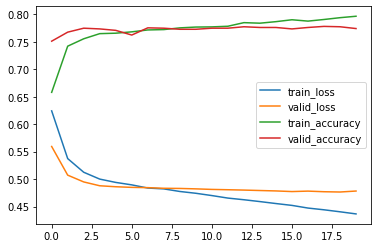

In [20]:
pd.DataFrame(history).plot(kind="line")

**Calcuate y_val_pred**

In [21]:
y_val_pred = np.argmax(np.array(model.predict(x_val), dtype=int), axis=-1)

**Confusion Matrix**

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
cm = confusion_matrix(y_val, y_val_pred)

<AxesSubplot:>

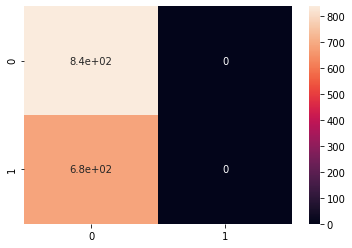

In [24]:
sns.heatmap(cm, annot=True)

## Submission

In [25]:
y_test = np.argmax(model.predict(x_test), axis=-1)

In [26]:
submission = pd.DataFrame({"id": test["id"], "target": y_test})

In [27]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [28]:
submission.to_csv("submission.csv", index=False)

## Conclusion
Now the Model can achive 78% accuracy both in validation dataset and test dataset which shown in Kaggle leader board. There's still a lot to improve.
